In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform

In [2]:
df_full = pd.read_csv('../Data/spy_full.csv')
df_month = pd.read_csv('../Data/spy_month.csv')
df_week = pd.read_csv('../Data/spy_week.csv')
df_full['date'] = pd.to_datetime(df_full['date'])
df_month['date'] = pd.to_datetime(df_month['date'])
df_week['date'] = pd.to_datetime(df_week['date'])
for i in range(1, 4):
    df_full[f'close{i}'] = df_full['close_price'].shift(i)
    df_full[f'log{i}'] = df_full['log_return'].shift(i)
    df_month[f'close{i}'] = df_month['close_price'].shift(i)
    df_month[f'log{i}'] = df_month['log_return'].shift(i)
    df_week[f'close{i}'] = df_week['close_price'].shift(i)
    df_week[f'log{i}'] = df_week['log_return'].shift(i)
df_week_test = df_full[~df_full['date'].isin(df_week['date'])]
df_month_test = df_full[~df_full['date'].isin(df_month['date'])]

In [45]:
close1 = XGBRegressor()
close1.fit(df_week[['close1']], df_week['close_price'])
close2 = XGBRegressor()
close2.fit(df_week[['close1', 'close2']], df_week['close_price'])
close3 = XGBRegressor()
close3.fit(df_week[['close1', 'close2', 'close3']], df_week['close_price'])
close1_price = close1.predict(df_week_test[['close1']])
close2_price = close2.predict(df_week_test[['close1', 'close2']])
close3_price = close3.predict(df_week_test[['close1', 'close2', 'close3']])
print('Using close price')
print('1 lag:', mean_squared_error(close1_price, df_week_test['close_price']))
print('2 lag:', mean_squared_error(close2_price, df_week_test['close_price']))
print('3 lag:', mean_squared_error(close3_price, df_week_test['close_price']))

Using close price
1 lag: 9.117822321228438
2 lag: 13.904543786121884
3 lag: 12.289520967177992


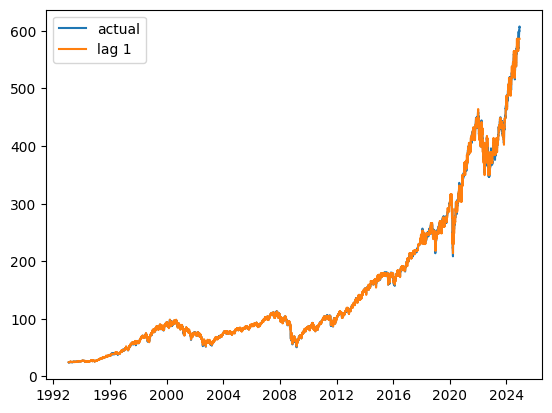

In [11]:
plt.plot(df_week_test['date'], df_week_test['close_price'], label='actual')
plt.plot(df_week_test['date'], close1_price, label='lag 1')
# plt.plot(df_week_test['date'],close2_price,label='lag 2')
# plt.plot(df_week_test['date'],close3_price,label='lag 3')
plt.legend()
plt.show()

In [5]:
log1 = XGBRegressor()
log1.fit(df_week[['log1']], df_week['log_return'])
log2 = XGBRegressor()
log2.fit(df_week[['log1', 'log2']], df_week['log_return'])
log3 = XGBRegressor()
log3.fit(df_week[['log1', 'log2', 'log3']], df_week['log_return'])
log1_returns = log1.predict(df_week_test[['log1']])
log2_returns = log2.predict(df_week_test[['log1', 'log2']])
log3_returns = log3.predict(df_week_test[['log1', 'log2', 'log3']])
for i in range(1, len(log1_returns)):
    log1_returns[i] += log1_returns[i - 1]
    log2_returns[i] += log2_returns[i - 1]
    log3_returns[i] += log3_returns[i - 1]
initial_price = df_week_test.iloc[0]['close_price']
log1_price = log1_returns * initial_price
log2_price = log2_returns * initial_price
log3_price = log3_returns * initial_price
print('Using log return')
print('1 lag:', mean_squared_error(log1_price, df_week_test['close_price']))
print('2 lag:', mean_squared_error(log2_price, df_week_test['close_price']))
print('3 lag:', mean_squared_error(log3_price, df_week_test['close_price']))

Using log return
1 lag: 4894.303528887026
2 lag: 23712.19695860014
3 lag: 11536.30655502875


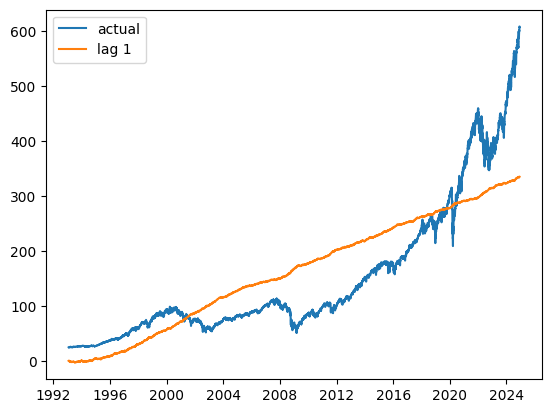

In [12]:
plt.plot(df_week_test['date'], df_week_test['close_price'], label='actual')
plt.plot(df_week_test['date'], log1_price, label='lag 1')
# plt.plot(df_week_test['date'],close2_price,label='lag 2')
# plt.plot(df_week_test['date'],close3_price,label='lag 3')
plt.legend()
plt.show()

In [31]:
future_weeks = 20 * 52  #20 years, 52 weeks each
lag1_future = close1_price
lag2_future = close2_price
lag3_future = close3_price
for i in range(future_weeks):
    lag1_future = np.append(lag1_future, close1.predict(lag1_future[-1].reshape(-1, 1)))
    lag2_future = np.append(lag2_future, close2.predict(lag2_future[-2:].reshape(-1, 2)))
    lag3_future = np.append(lag3_future, close3.predict(lag3_future[-3:].reshape(-1, 3)))

In [ ]:
n = len(df_week_test)
x = [*range(n)] + [(i + 1) * 7 + n for i in range(future_weeks)]
plt.plot(x, lag1_future, label='lag 1')
# plt.plot(x, lag2_future, label='lag 2')
# plt.plot(x, lag3_future, label='lag 3')
plt.plot([*range(n)], df_week_test['close_price'], label='actual')
plt.legend()
plt.show()

In [59]:
pd.concat([df_week_test['close_price'], pd.Series(close1_price), pd.Series(close2_price), pd.Series(close3_price)],
          axis=1)

,close_price,0,1,2
0,24.61,24.781225,24.783337,24.761969
1,24.78,25.058186,25.101135,25.143774
2,24.84,25.058186,25.159912,24.455713
3,25.10,25.058186,25.159912,25.422834
4,25.20,24.982666,24.811359,25.367348
...,...,...,...,...
8016,602.55,586.251343,586.711670,589.630615
8017,603.63,586.251343,586.711670,589.630615
8018,603.91,586.251343,586.711670,589.630615
8019,607.66,586.251343,586.711670,589.630615


In [ ]:
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': randint(1, 11),
#     'eta': uniform(loc=0, scale=0.5)
# }
# xgb = XGBRegressor()
# search = RandomizedSearchCV(xgb, param_dist, random_state=42).fit(df_month.drop(columns=['simple_return', 'date']), df_month['simple_return'])

In [ ]:
# best_model = search.best_estimator_
# best_model.predict(df_month_test.drop(columns=['simple_return', 'date']))

In [ ]:
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': randint(1, 11),
#     'eta': uniform(loc=0, scale=0.5)
# }
# xgb = XGBRegressor()
# search = RandomizedSearchCV(xgb, param_dist, random_state=42).fit(df_week.drop(columns=['simple_return', 'date']), df_week['simple_return'])

In [ ]:
# best_model = search.best_estimator_
# best_model.predict(df_week_test.drop(columns=['simple_return', 'date']))